## 导库

In [14]:
import os, argparse, time, datetime, sys, shutil, stat, torch
import torchvision.models as models
import torchvision.utils as vutils
from torch.utils.data import DataLoader
from torch.autograd import Variable
import torch.nn as nn
from util.MF_dataset import MF_dataset
from util.util import compute_results, visualize
from sklearn.metrics import confusion_matrix
from scipy.io import savemat
import torch.nn.functional as F
import numpy as np
from PIL import Image
from util.augmentation import RandomFlip, RandomCrop, RandomCropOut, RandomBrightness, RandomNoise
from torch.utils.tensorboard import SummaryWriter
from torchvision.models import ResNet152_Weights, ResNet50_Weights

## 模型搭建

### 注意力机制

In [8]:
class AttentionFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.attetion = nn.Sequential(
            nn.Conv2d(channels * 2, channels // 2, kernel_size=3, padding=1),
            nn.BatchNorm2d(channels // 2),
            nn.ReLU(),
            nn.Conv2d(channels // 2, 2, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        self.rgb_confidence = nn.Parameter(torch.tensor(1.0))
        self.thermal_confidence = nn.Parameter(torch.tensor(1.0))

        self.register_buffer('rgb_prior', torch.ones(1))
        self.register_buffer('thermal_prior', torch.ones(1))
        self.momentum = 0.9

    def update(self, rgb_purity, thermal_purity):
        self.rgb_prior = self.momentum * self.rgb_prior + (1-self.momentum)* rgb_purity
        self.thermal_prior = self.momentum * self.thermal_prior + (1-self.momentum) * thermal_purity
        self.rgb_prior.data.clamp_(0.1, 1.0)
        self.thermal_prior.data.clamp_(0.1, 1.0)

    def forward(self, rgb_feat, thermal_feat):
        combined = torch.cat([rgb_feat, thermal_feat], dim=1)
        attention_weights = self.attention(combined)  # [B,2,H,W]

        # 将置信度参数转换为与attention_weights相同的维度
        rgb_conf = torch.sigmoid(self.rgb_confidence).view(1,1,1,1)  # [1,1,1,1]
        thermal_conf = torch.sigmoid(self.thermal_confidence).view(1,1,1,1)

        # 动态调整权重（关键修改点）
        adjusted_weights = torch.cat([
            attention_weights[:,0:1] * rgb_conf * self.rgb_prior,
            attention_weights[:,1:2] * thermal_conf * self.thermal_prior
        ], dim=1)

        # 重新归一化
        norm_weights = adjusted_weights / (adjusted_weights.sum(dim=1, keepdim=True) + 1e-8)

        return rgb_feat * norm_weights[:,0:1] + thermal_feat * norm_weights[:,1:2]

### 网络定义

In [9]:
class RTFNet(nn.Module):

    def __init__(self, n_class):
        super(RTFNet, self).__init__()  # 初始化

        self.num_resnet_layers = 152

        if self.num_resnet_layers == 50:
            resnet_raw_model1 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
            resnet_raw_model2 = models.resnet50(weights=ResNet50_Weights.DEFAULT)
            self.inplanes = 2048
        elif self.num_resnet_layers == 152:
            resnet_raw_model1 = models.resnet152(weights=ResNet152_Weights.DEFAULT)
            resnet_raw_model2 = models.resnet152(weights=ResNet152_Weights.DEFAULT)
            self.inplanes = 2048

        ########  Thermal ENCODER  ########

        self.encoder_thermal_conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.encoder_thermal_conv1.weight.data = torch.unsqueeze(torch.mean(resnet_raw_model1.conv1.weight.data, dim=1),
                                                                 dim=1)
        self.encoder_thermal_bn1 = resnet_raw_model1.bn1
        self.encoder_thermal_relu = resnet_raw_model1.relu
        self.encoder_thermal_maxpool = resnet_raw_model1.maxpool
        self.encoder_thermal_layer1 = resnet_raw_model1.layer1
        self.encoder_thermal_layer2 = resnet_raw_model1.layer2
        self.encoder_thermal_layer3 = resnet_raw_model1.layer3
        self.encoder_thermal_layer4 = resnet_raw_model1.layer4

        ########  RGB ENCODER  ########

        self.encoder_rgb_conv1 = resnet_raw_model2.conv1
        self.encoder_rgb_bn1 = resnet_raw_model2.bn1
        self.encoder_rgb_relu = resnet_raw_model2.relu
        self.encoder_rgb_maxpool = resnet_raw_model2.maxpool
        self.encoder_rgb_layer1 = resnet_raw_model2.layer1
        self.encoder_rgb_layer2 = resnet_raw_model2.layer2
        self.encoder_rgb_layer3 = resnet_raw_model2.layer3
        self.encoder_rgb_layer4 = resnet_raw_model2.layer4

        ########  Fusion   ########
        self.fusion1 = AttentionFusion(64)
        self.fusion2 = AttentionFusion(256)
        self.fusion3 = AttentionFusion(512)
        self.fusion4 = AttentionFusion(1024)
        self.fusion5 = AttentionFusion(2048)
        self.fusion1st = AttentionFusion(2)

        self.register_buffer('last_rgb_pred', None)
        self.register_buffer('last_thermal_feat', None)
        self.register_buffer('last_purity', torch.zeros(2))

        ########  DECODER  ########

        self.deconv1 = self._make_transpose_layer(TransBottleneck, self.inplanes // 2, 2,
                                                  stride=2)  # using // for python 3.6
        self.deconv2 = self._make_transpose_layer(TransBottleneck, self.inplanes // 2, 2,
                                                  stride=2)  # using // for python 3.6
        self.deconv3 = self._make_transpose_layer(TransBottleneck, self.inplanes // 2, 2,
                                                  stride=2)  # using // for python 3.6
        self.deconv4 = self._make_transpose_layer(TransBottleneck, self.inplanes // 2, 2,
                                                  stride=2)  # using // for python 3.6
        self.deconv5 = self._make_transpose_layer(TransBottleneck, n_class, 2, stride=2)

        self.side_conv1 = nn.Conv2d(1024, n_class, kernel_size=1)
        self.side_conv2 = nn.Conv2d(512, n_class, kernel_size=1)
        self.side_conv3 = nn.Conv2d(256, n_class, kernel_size=1)
        self.side_conv4 = nn.Conv2d(128, n_class, kernel_size=1)

        self.detail_enhance = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, n_class, kernel_size=1)
        )


    def _make_transpose_layer(self, block, planes, blocks, stride=1):

        upsample = None
        if stride != 1:
            upsample = nn.Sequential(
                nn.ConvTranspose2d(self.inplanes, planes, kernel_size=2, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(planes),
            )
        elif self.inplanes != planes:
            upsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(planes),
            )

        for m in upsample.modules():  # 遍历卷积层 初始化权重
            if isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

        layers = []

        for i in range(1, blocks):
            layers.append(block(self.inplanes, self.inplanes))

        layers.append(block(self.inplanes, planes, stride, upsample))
        self.inplanes = planes

        return nn.Sequential(*layers)  # 解包传参

    def evaluate_purity(self, pred, rgb_feat=None, thermal_feat=None):
    # 1. 基础纯净度：基于预测结果的熵
        pred_probs = F.softmax(pred, dim=1)
        pred_entropy = -torch.sum(pred_probs * torch.log(pred_probs + 1e-10), dim=1)
        base_purity = 1 - pred_entropy.mean()  # 基础纯净度

        rgb_purity = thermal_purity = base_purity

        if rgb_feat is not None:
            rgb_grad = torch.mean(torch.abs(rgb_feat[:, :, :-1] - rgb_feat[:, :, 1:]))
            rgb_purity = base_purity * (1 + 0.5 * torch.sigmoid(rgb_grad - 0.5))

        if thermal_feat is not None:
            thermal_mean = torch.mean(thermal_feat)
            thermal_std = torch.std(thermal_feat)
            thermal_snr = thermal_mean / (thermal_std + 1e-10)
            thermal_purity = base_purity * (1 + 0.3 * torch.tanh(thermal_snr))

        return rgb_purity, thermal_purity

    def forward(self, input, verbose=False, update_prior=False):

        rgb = input[:, :3]
        thermal = input[:, 3:]

        # rgb = self.fusion1st(rgb, thermal)

        if verbose: print("rgb.size() original: ", rgb.size())  # (480, 640)
        if verbose: print("thermal.size() original: ", thermal.size())  # (480, 640)

        rgb = self.encoder_rgb_conv1(rgb)
        if verbose: print("rgb.size() after conv1: ", rgb.size())  # (240, 320)
        rgb = self.encoder_rgb_bn1(rgb)
        if verbose: print("rgb.size() after bn1: ", rgb.size())  # (240, 320)
        rgb = self.encoder_rgb_relu(rgb)
        if verbose: print("rgb.size() after relu: ", rgb.size())  # (240, 320)

        thermal = self.encoder_thermal_conv1(thermal)
        if verbose: print("thermal.size() after conv1: ", thermal.size())  # (240, 320)
        thermal = self.encoder_thermal_bn1(thermal)
        if verbose: print("thermal.size() after bn1: ", thermal.size())  # (240, 320)
        thermal = self.encoder_thermal_relu(thermal)
        if verbose: print("thermal.size() after relu: ", thermal.size())  # (240, 320)

        # rgb = rgb + thermal
        # rgb = self.fusion1(rgb, thermal) * self.fusion1.rgb_confidence.sigmoid()  # 融合一次

        rgb = self.encoder_rgb_maxpool(rgb)
        if verbose: print("rgb.size() after maxpool: ", rgb.size())  # (120, 160)

        thermal = self.encoder_thermal_maxpool(thermal)
        if verbose: print("thermal.size() after maxpool: ", thermal.size())  # (120, 160)

        rgb = self.encoder_rgb_layer1(rgb)
        if verbose: print("rgb.size() after layer1: ", rgb.size())  # (120, 160)
        thermal = self.encoder_thermal_layer1(thermal)
        if verbose: print("thermal.size() after layer1: ", thermal.size())  # (120, 160)

        # rgb = self.fusion2(rgb, thermal) * self.fusion2.rgb_confidence.sigmoid()
        # rgb = rgb + thermal

        rgb = self.encoder_rgb_layer2(rgb)
        if verbose: print("rgb.size() after layer2: ", rgb.size())  # (60, 80)
        thermal = self.encoder_thermal_layer2(thermal)
        if verbose: print("thermal.size() after layer2: ", thermal.size())  # (60, 80)

        # rgb = self.fusion3(rgb, thermal)
        rgb = rgb + thermal


        rgb = self.encoder_rgb_layer3(rgb)
        if verbose: print("rgb.size() after layer3: ", rgb.size())  # (30, 40)
        thermal = self.encoder_thermal_layer3(thermal)
        if verbose: print("thermal.size() after layer3: ", thermal.size())  # (30, 40)

        # rgb = self.fusion4(rgb, thermal)
        rgb = rgb + thermal
        ######################################################################

        rgb = self.encoder_rgb_layer4(rgb)
        if verbose: print("rgb.size() after layer4: ", rgb.size())  # (15, 20)
        thermal = self.encoder_thermal_layer4(thermal)
        if verbose: print("thermal.size() after layer4: ", thermal.size())  # (15, 20)

        fuse = rgb + thermal

        ######################################################################

        # decoder

        fuse = self.deconv1(fuse)
        if verbose: print("fuse after deconv1: ", fuse.size())  # (30, 40)
        fuse = self.deconv2(fuse)
        if verbose: print("fuse after deconv2: ", fuse.size())  # (60, 80)
        fuse = self.deconv3(fuse)
        if verbose: print("fuse after deconv3: ", fuse.size())  # (120, 160)
        fuse = self.deconv4(fuse)
        if verbose: print("fuse after deconv4: ", fuse.size())  # (240, 320)
        fuse = self.deconv5(fuse)
        if verbose: print("fuse after deconv5: ", fuse.size())  # (480, 640)

        return fuse

class TransBottleneck(nn.Module):

    def __init__(self, inplanes, planes, stride=1, upsample=None):
        super(TransBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        if upsample is not None and stride != 1:
            self.conv3 = nn.ConvTranspose2d(planes, planes, kernel_size=2, stride=stride, padding=0, bias=False)
        else:
            self.conv3 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)

        self.bn3 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.upsample = upsample
        self.stride = stride

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.ConvTranspose2d):
                nn.init.xavier_uniform_(m.weight.data)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):  # 残差连接
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.upsample is not None:
            residual = self.upsample(x)

        out += residual
        out = self.relu(out)

        return out

### 测试运行

In [10]:
def unit_test():
    num_minibatch = 1
    rgb = torch.randn(num_minibatch, 3, 480, 640)
    thermal = torch.randn(num_minibatch, 1, 480, 640)
    rtf_net = RTFNet(9)
    input = torch.cat((rgb, thermal), dim=1)
    rtf_net(input)
    # print('The model: ', rtf_net.modules)
    print('Accomplished！')

if __name__ == '__main__':
    unit_test()

Accomplished！


## 模型训练

In [ ]:
parser = argparse.ArgumentParser(description='Train with pytorch')
parser.add_argument('--model_name', '-m', type=str, default='RTFNet')
#batch_size: RTFNet-152: 2; RTFNet-101: 2; RTFNet-50: 3; RTFNet-34: 10; RTFNet-18: 15;
parser.add_argument('--batch_size', '-b', type=int, default=2)
parser.add_argument('--lr_start', '-ls', type=float, default=0.01)
parser.add_argument('--gpu', '-g', type=int, default=0)
#############################################################################################
parser.add_argument('--lr_decay', '-ld', type=float, default=0.95)
parser.add_argument('--epoch_max', '-em', type=int, default=1) # please stop training mannully
parser.add_argument('--epoch_from', '-ef', type=int, default=0)
parser.add_argument('--num_workers', '-j', type=int, default=2)
parser.add_argument('--n_class', '-nc', type=int, default=9)
parser.add_argument('--data_dir', '-dr', type=str, default='./dataset/')
# 替换原来的 parse_args() 调用
args, unknown = parser.parse_known_args()  # 自动忽略未定义的参数
args.file_name = "final.pth"
#############################################################################################

augmentation_methods = [
    RandomFlip(prob=0.5),
    RandomCrop(crop_rate=0.1, prob=1.0),
    # RandomCropOut(crop_rate=0.2, prob=1.0),
    # RandomBrightness(bright_range=0.15, prob=0.9),
    # RandomNoise(noise_range=5, prob=0.9),
]
writer = SummaryWriter()
def train(epo, model, train_loader, optimizer):
    model.train()
    for it, (images, labels, names) in enumerate(train_loader):
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        images = Variable(images).to(device)
        labels = Variable(labels).to(device)
        start_t = time.time() # time.time() returns the current time
        optimizer.zero_grad()
        logits = model(images)
        loss = F.cross_entropy(logits, labels)  # Note that the cross_entropy function has already include the softmax function
        loss.backward()
        optimizer.step()
        lr_this_epo=0
        for param_group in optimizer.param_groups:
            lr_this_epo = param_group['lr']
        print('Train: %s, epo %s/%s, iter %s/%s, lr %.8f, %.2f img/sec, loss %.4f, time %s' \
            % (args.model_name, epo, args.epoch_max, it+1, len(train_loader), lr_this_epo, len(names)/(time.time()-start_t), float(loss),
              datetime.datetime.now().replace(microsecond=0)-start_datetime))
        if accIter['train'] % 1 == 0:
            writer.add_scalar('Train/loss', loss, accIter['train'])
        view_figure = True # note that I have not colorized the GT and predictions here
        if accIter['train'] % 500 == 0:
            if view_figure:
                input_rgb_images = vutils.make_grid(images[:,:3], nrow=8, padding=10) # can only display 3-channel images, so images[:,:3]
                writer.add_image('Train/input_rgb_images', input_rgb_images, accIter['train'])
                scale = max(1, 255//args.n_class) # label (0,1,2..) is invisable, multiply a constant for visualization
                groundtruth_tensor = labels.unsqueeze(1) * scale  # mini_batch*480*640 -> mini_batch*1*480*640
                groundtruth_tensor = torch.cat((groundtruth_tensor, groundtruth_tensor, groundtruth_tensor), 1)  # change to 3-channel for visualization
                groudtruth_images = vutils.make_grid(groundtruth_tensor, nrow=8, padding=10)
                writer.add_image('Train/groudtruth_images', groudtruth_images, accIter['train'])
                predicted_tensor = logits.argmax(1).unsqueeze(1) * scale # mini_batch*args.n_class*480*640 -> mini_batch*480*640 -> mini_batch*1*480*640
                predicted_tensor = torch.cat((predicted_tensor, predicted_tensor, predicted_tensor),1) # change to 3-channel for visualization, mini_batch*1*480*640
                predicted_images = vutils.make_grid(predicted_tensor, nrow=8, padding=10)
                writer.add_image('Train/predicted_images', predicted_images, accIter['train'])
        accIter['train'] = accIter['train'] + 1


def validation(epo, model, val_loader):
    model.eval()
    with torch.no_grad():
        for it, (images, labels, names) in enumerate(val_loader):
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            start_t = time.time() # time.time() returns the current time
            logits = model(images)
            loss = F.cross_entropy(logits, labels)  # Note that the cross_entropy function has already include the softmax function
            print('Val: %s, epo %s/%s, iter %s/%s, %.2f img/sec, loss %.4f, time %s' \
                  % (args.model_name, epo, args.epoch_max, it + 1, len(val_loader), len(names)/(time.time()-start_t), float(loss),
                    datetime.datetime.now().replace(microsecond=0)-start_datetime))
            if accIter['val'] % 1 == 0:
                writer.add_scalar('Validation/loss', loss, accIter['val'])
            view_figure = False  # note that I have not colorized the GT and predictions here
            if accIter['val'] % 100 == 0:
                if view_figure:
                    input_rgb_images = vutils.make_grid(images[:, :3], nrow=8, padding=10)  # can only display 3-channel images, so images[:,:3]
                    writer.add_image('Validation/input_rgb_images', input_rgb_images, accIter['val'])
                    scale = max(1, 255 // args.n_class)  # label (0,1,2..) is invisable, multiply a constant for visualization
                    groundtruth_tensor = labels.unsqueeze(1) * scale  # mini_batch*480*640 -> mini_batch*1*480*640
                    groundtruth_tensor = torch.cat((groundtruth_tensor, groundtruth_tensor, groundtruth_tensor), 1)  # change to 3-channel for visualization
                    groudtruth_images = vutils.make_grid(groundtruth_tensor, nrow=8, padding=10)
                    writer.add_image('Validation/groudtruth_images', groudtruth_images, accIter['val'])
                    predicted_tensor = logits.argmax(1).unsqueeze(1)*scale  # mini_batch*args.n_class*480*640 -> mini_batch*480*640 -> mini_batch*1*480*640
                    predicted_tensor = torch.cat((predicted_tensor, predicted_tensor, predicted_tensor), 1)  # change to 3-channel for visualization, mini_batch*1*480*640
                    predicted_images = vutils.make_grid(predicted_tensor, nrow=8, padding=10)
                    writer.add_image('Validation/predicted_images', predicted_images, accIter['val'])
            accIter['val'] += 1

def testing(epo, model, test_loader):
    model.eval()
    conf_total = np.zeros((args.n_class, args.n_class))
    label_list = ["unlabeled", "car", "person", "bike", "curve", "car_stop", "guardrail", "color_cone", "bump"]
    testing_results_file = os.path.join(weight_dir, 'testing_results_file.txt')
    with torch.no_grad():
        for it, (images, labels, names) in enumerate(test_loader):
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            logits = model(images)
            label = labels.cpu().numpy().squeeze().flatten()
            prediction = logits.argmax(1).cpu().numpy().squeeze().flatten() # prediction and label are both 1-d array, size: minibatch*640*480
            conf = confusion_matrix(y_true=label, y_pred=prediction, labels=[0,1,2,3,4,5,6,7,8]) # conf is args.n_class*args.n_class matrix, vertical axis: groundtruth, horizontal axis: prediction
            conf_total += conf
            print('Test: %s, epo %s/%s, iter %s/%s, time %s' % (args.model_name, epo, args.epoch_max, it+1, len(test_loader),
                 datetime.datetime.now().replace(microsecond=0)-start_datetime))
    precision, recall, IoU = compute_results(conf_total)
    writer.add_scalar('Test/average_precision',precision.mean(), epo)
    writer.add_scalar('Test/average_recall', recall.mean(), epo)
    writer.add_scalar('Test/average_IoU', IoU.mean(), epo)
    for i in range(len(precision)):
        writer.add_scalar("Test(class)/precision_class_%s" % label_list[i], precision[i], epo)
        writer.add_scalar("Test(class)/recall_class_%s"% label_list[i], recall[i],epo)
        writer.add_scalar('Test(class)/Iou_%s'% label_list[i], IoU[i], epo)
    if epo==0:
        with open(testing_results_file, 'w') as f:
            f.write("# %s, initial lr: %s, batch size: %s, date: %s \n" %(args.model_name, args.lr_start, args.batch_size, datetime.date.today()))
            f.write("# epoch: unlabeled, car, person, bike, curve, car_stop, guardrail, color_cone, bump, average(nan_to_num). (Acc %, IoU %)\n")
    with open(testing_results_file, 'a') as f:
        f.write(str(epo)+': ')
        for i in range(len(precision)):
            f.write('%0.4f, %0.4f, ' % (100*recall[i], 100*IoU[i]))
        f.write('%0.4f, %0.4f\n' % (100*np.mean(np.nan_to_num(recall)), 100*np.mean(np.nan_to_num(IoU))))
    print('saving testing results.')
    with open(testing_results_file, "r") as file:
        writer.add_text('testing_results', file.read().replace('\n', '  \n'), epo)

if __name__ == '__main__':
    model = eval(args.model_name)(n_class=args.n_class)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)  # 将模型移动到 CPU
    optimizer = torch.optim.SGD(model.parameters(), lr=args.lr_start, momentum=0.9, weight_decay=0.0005)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=args.lr_decay, last_epoch=-1)

    # preparing folders
    weight_dir = os.path.join("./runs", args.model_name)
    print('from epoch %d / %s' % (args.epoch_from, args.epoch_max))
    print('weight will be saved in: %s' % weight_dir)

    train_dataset = MF_dataset(data_dir=args.data_dir, split='train', transform=augmentation_methods)
    val_dataset  = MF_dataset(data_dir=args.data_dir, split='val')
    test_dataset = MF_dataset(data_dir=args.data_dir, split='test')

    train_loader  = DataLoader(
        dataset     = train_dataset,
        batch_size  = args.batch_size,
        shuffle     = True,
        num_workers = args.num_workers,
        pin_memory  = True,
        drop_last   = False
    )
    val_loader  = DataLoader(
        dataset     = val_dataset,
        batch_size  = args.batch_size,
        shuffle     = False,
        num_workers = args.num_workers,
        pin_memory  = True,
        drop_last   = False
    )
    test_loader = DataLoader(
        dataset      = test_dataset,
        batch_size   = args.batch_size,
        shuffle      = False,
        num_workers  = args.num_workers,
        pin_memory   = True,
        drop_last    = False
    )
    start_datetime = datetime.datetime.now().replace(microsecond=0)
    accIter = {'train': 0, 'val': 0}
    for epo in range(args.epoch_from, args.epoch_max):
        print('\ntrain %s, epo #%s begin...' % (args.model_name, epo))
        train(epo, model, train_loader, optimizer)
        validation(epo, model, val_loader)

    checkpoint_model_file = os.path.join(weight_dir, str(epo) + '.pth')
    print('saving check point %s: ' % checkpoint_model_file)
    torch.save(model.state_dict(), checkpoint_model_file)

    testing(epo, model, test_loader) # testing is just for your reference, you can comment this line during training
    scheduler.step() # if using pytorch 1.1 or above, please put this statement here


## 测试运行

In [ ]:
parser = argparse.ArgumentParser(description='Test with pytorch')

parser.add_argument('--model_name', '-m', type=str, default='RTFNet')
parser.add_argument('--weight_name', '-w', type=str, default='RTFNET_152') # RTFNet_152, RTFNet_50, please change the number of layers in the network file
parser.add_argument('--file_name', '-fi', type=str, default='final.pth')
parser.add_argument('--dataset_split', '-d', type=str, default='test') # test, test_day, test_night
parser.add_argument('--img_height', '-ih', type=int, default=480)
parser.add_argument('--img_width', '-iw', type=int, default=640)
parser.add_argument('--num_workers', '-j', type=int, default=8)
parser.add_argument('--n_class', '-nc', type=int, default=9)
parser.add_argument('--data_dir', '-dr', type=str, default='./dataset/')
parser.add_argument('--model_dir', '-wd', type=str, default='./weights_backup/')


args = parser.parse_args()
args.file_name = "final.pth"
if __name__ == '__main__':
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_dir = os.path.join(args.model_dir, args.weight_name)
    # if os.path.exists(model_dir) is False:
    #     sys.exit("the %s does not exit." %(model_dir))
    model_file = os.path.join(model_dir, args.file_name)


    conf_total = np.zeros((args.n_class, args.n_class))
    model = eval(args.model_name)(n_class=args.n_class)
    model = model.to(device)

    pretrained_weight = torch.load(model_file, map_location='cpu', weights_only=True)
    own_state = model.state_dict()
    for name, param in pretrained_weight.items():
        if name not in own_state:
            continue
        own_state[name].copy_(param)

    batch_size = 1
    test_dataset  = MF_dataset(data_dir=args.data_dir, split=args.dataset_split, input_h=args.img_height, input_w=args.img_width)
    test_loader  = DataLoader(
        dataset     = test_dataset,
        batch_size  = batch_size,
        shuffle     = False,
        num_workers = args.num_workers,
        pin_memory  = True,
        drop_last   = False
    )
    ave_time_cost = 0.0

    model.eval()
    with torch.no_grad():
        for it, (images, labels, names) in enumerate(test_loader):
            images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            start_time = time.time()
            logits = model(images)  # logits.size(): mini_batch*num_class*480*640
            end_time = time.time()
            if it>=5: # # ignore the first 5 frames
                ave_time_cost += (end_time-start_time)
            # convert tensor to numpy 1d array
            label = labels.detach().cpu().numpy().squeeze().flatten()
            prediction = logits.argmax(1).detach().cpu().numpy().squeeze().flatten() # prediction and label are both 1-d array, size: minibatch*640*480
            # generate confusion matrix frame-by-frame
            # conf = confusion_matrix(y_true=label, y_pred=prediction, labels=[0,1,2,3,4,5,6,7,8]) # conf is an n_class*n_class matrix, vertical axis: groundtruth, horizontal axis: prediction
            # conf_total += conf
            # save demo images
            visualize(image_name=names, predictions=logits.argmax(1), weight_name=args.weight_name)
            print("frame %d/%d, %s, time cost: %.2f ms, demo result saved."
                  %(it+1, len(test_loader), names, (end_time-start_time)*1000))

frame 1/20, ('01500D',), time cost: 1381.78 ms, demo result saved.
frame 2/20, ('01501D',), time cost: 1262.53 ms, demo result saved.
frame 3/20, ('01502D',), time cost: 1011.41 ms, demo result saved.
frame 4/20, ('01503D',), time cost: 927.35 ms, demo result saved.
frame 5/20, ('01504D',), time cost: 919.30 ms, demo result saved.
frame 6/20, ('01505D',), time cost: 971.62 ms, demo result saved.
frame 7/20, ('01506D',), time cost: 959.92 ms, demo result saved.
frame 8/20, ('01507D',), time cost: 954.81 ms, demo result saved.
frame 9/20, ('01508D',), time cost: 971.74 ms, demo result saved.
frame 10/20, ('01509D',), time cost: 1004.99 ms, demo result saved.
frame 11/20, ('01200N',), time cost: 1063.20 ms, demo result saved.
frame 12/20, ('01201N',), time cost: 1006.08 ms, demo result saved.
frame 13/20, ('01202N',), time cost: 980.92 ms, demo result saved.
frame 14/20, ('01203N',), time cost: 983.25 ms, demo result saved.
frame 15/20, ('01204N',), time cost: 1000.63 ms, demo result save

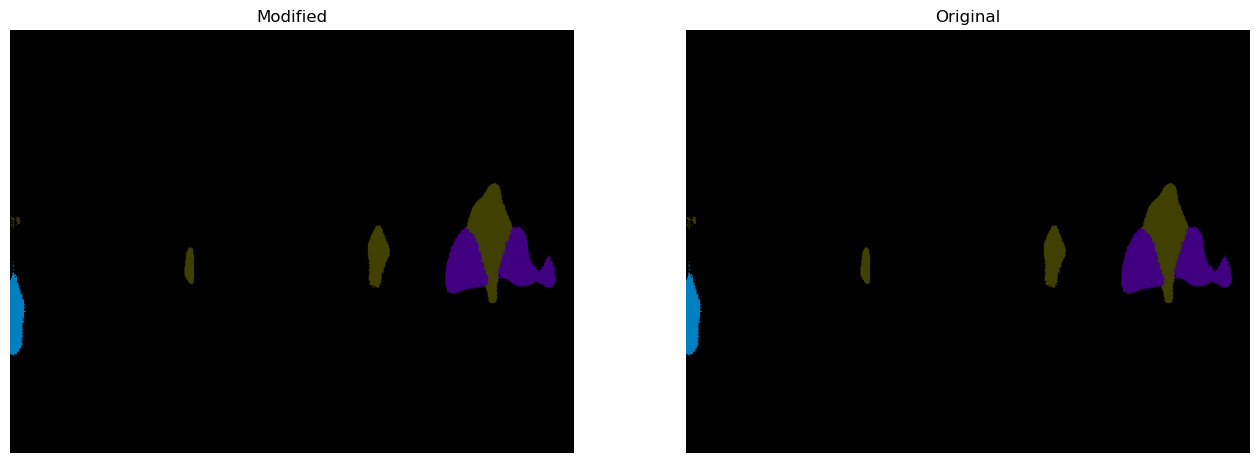

In [16]:
import matplotlib.pyplot as plt
import os
pic = "1500D"
# 指定图像路径（例如测试集中的第一张图像）
image_path = 'runs/Predict_RTFNET_152_0{}.png'.format(pic)  # 根据实际路径调整
image_path1 = 'runs/Pred_RTFNet_152_0{}.png'.format(pic)
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
img = plt.imread(image_path)
plt.imshow(img)
plt.axis('off')  # 隐藏坐标轴
plt.title("Modified")
plt.subplot(1, 2, 2)
img1 = plt.imread(image_path1)
plt.imshow(img1)
plt.axis('off')  # 隐藏坐标轴
plt.title("Original")
plt.show()